# Landtype classification using Cloude-Pottier decomposition on polarimetric data

Objectives:
Download usable SAR data from the SatSao test product (https://catalogos.conae.gov.ar/catalogo/catalogoSatSaocomAdel.html)
+ Zona de los alrededores de Monte Maíz, Provincia de Córdoba, Argentina (PRODUCTO STRIPMAP QUAD POL Nivel L1A (SLC))
+ This database contains the complete polarization with an L1A level that corresponds to the raw data with the required complex data (at a higher pre-processing level, there is only the magnitude).

Perform a Cloude-Pottier decomposition and use the output entropy and angle to perform land classification using the following functions
+ load_sar_data which load, plot and / or extract data subset

In [4]:
import os, sys
import numpy as np

import xarray as xr
import rasterio

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Rectangle
# from osgeo import gdal

from scipy.ndimage import uniform_filter
from scipy.interpolate import griddata

import psutil
import time

In [5]:
def load_sar_data(file_path, plot=False, xslice=slice(None), yslice=slice(None)):
    """
    Load SAR complex data from a file and optionally plot magnitude and angle.

    Parameters:
        file_path (str): Path to the SAR data file.
        plot (bool): Whether to plot the magnitude and angle side by side.

    Returns:
        complex ndarray: The loaded SAR complex data.
    """

    try:
        dataset = rasterio.open(file_path) 
        # Read the first band
        band1 = dataset.read(1)

        # Extract the slice
        sliced_data = band1[xslice, yslice]

        # Convert to complex if necessary (example placeholder)
        if band1.dtype in [np.complex64, np.complex128]:
            complex_data = sliced_data
        else:
            raise ValueError("Unexpected data format; complex type expected.")


        # Plot magnitude and angle if requested
        if plot:
            magnitude = np.abs(complex_data)
            angle = np.angle(complex_data)

            # Percentile scaling for visualization
            lower = np.percentile(magnitude, 2)
            upper = np.percentile(magnitude, 98)

            # Side-by-side plot
            fig, axs = plt.subplots(1, 2, figsize=(15, 6))
            
            # Magnitude plot
            im0 = axs[0].imshow(magnitude, cmap='gray', vmin=lower, vmax=upper)
            axs[0].set_title("Magnitude")
            axs[0].set_xlabel("Range")
            axs[0].set_ylabel("Azimuth")
            fig.colorbar(im0, ax=axs[0], label="Magnitude")

            # Angle plot
            im1 = axs[1].imshow(angle, cmap='hsv')
            axs[1].set_title("Angle")
            axs[1].set_xlabel("Range")
            fig.colorbar(im1, ax=axs[1], label="Angle (Radians)")

            plt.tight_layout()
            plt.show()

        return complex_data
    
    except Exception as e:
        print(f"Error: {e}")
        return None

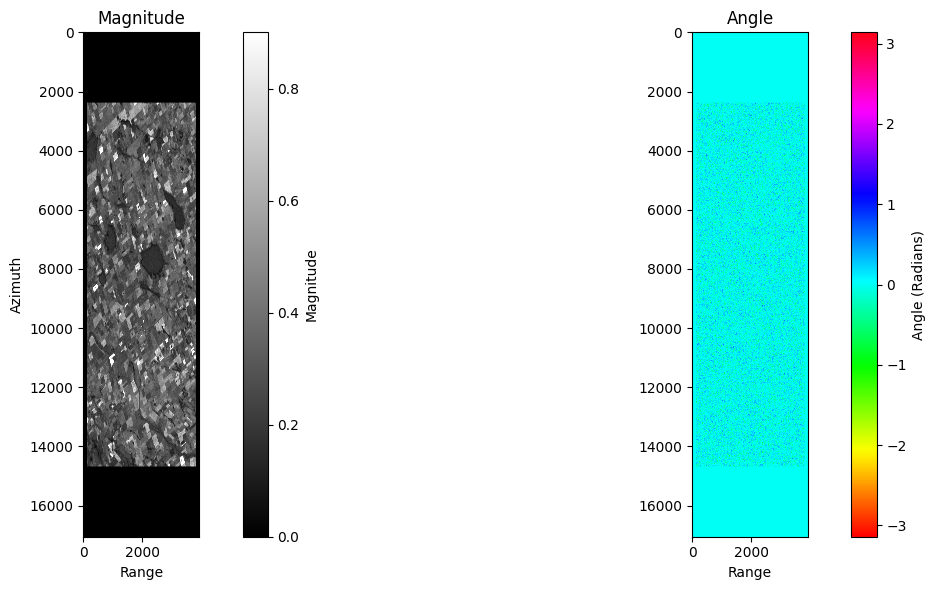

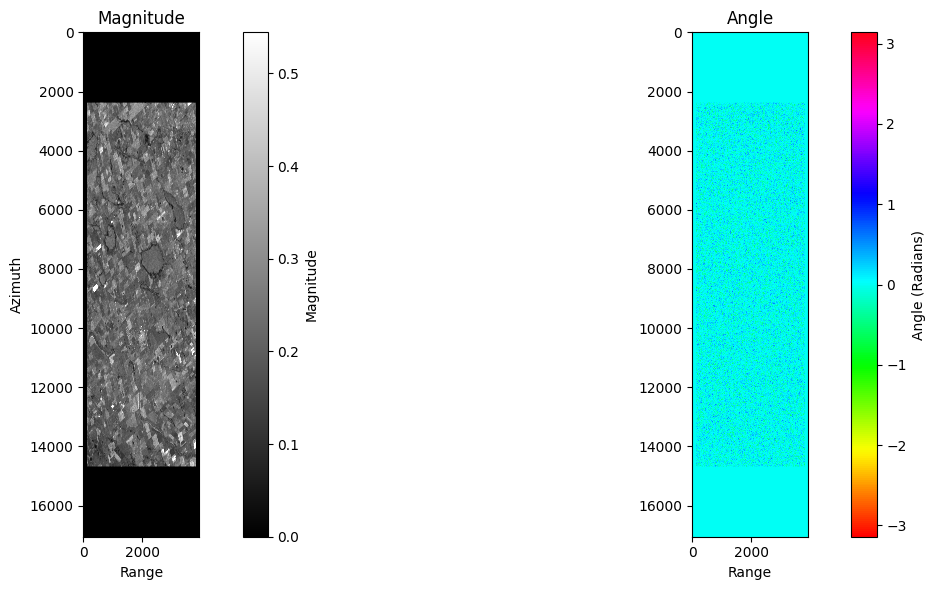

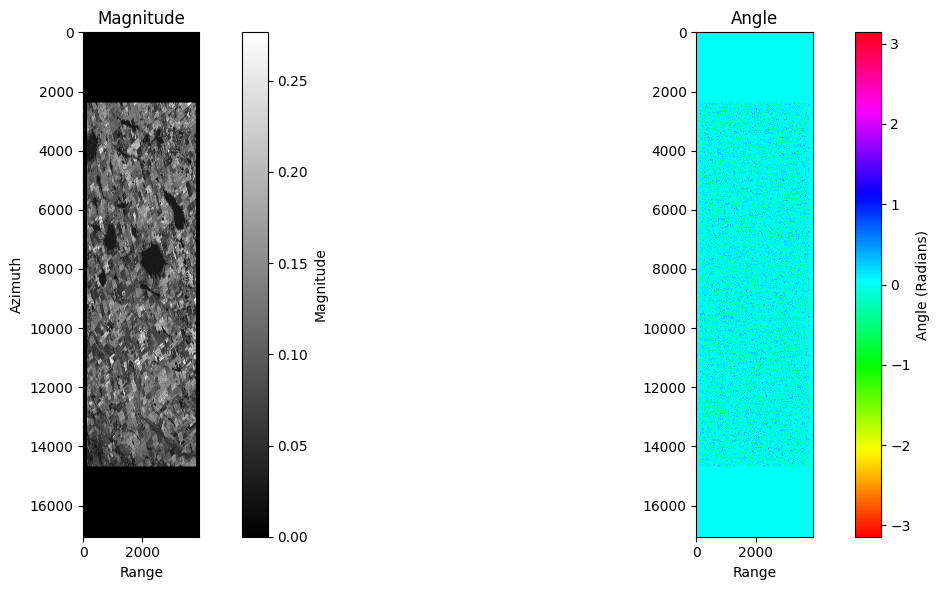

In [6]:
# Define the base path and file paths for polarization data
base_path = "/home/renaud/Polarimetric_landcover/data/SatSao_MonteMaiz_cordoba"

hh_image_file = os.path.join(base_path, "S1A_OPER_SAR_EOSSP__CORE_L1A_OLVF_20200703T145917", "Data", "slc-acqId0000011802-a-sm6-0000000000-s6qp-hh")
hv_image_file = os.path.join(base_path, "S1A_OPER_SAR_EOSSP__CORE_L1A_OLVF_20200703T145917", "Data", "slc-acqId0000011802-a-sm6-0000000000-s6qp-hv")
vh_image_file = os.path.join(base_path, "S1A_OPER_SAR_EOSSP__CORE_L1A_OLVF_20200703T145917", "Data", "slc-acqId0000011802-a-sm6-0000000000-s6qp-vh")
vv_image_file = os.path.join(base_path, "S1A_OPER_SAR_EOSSP__CORE_L1A_OLVF_20200703T145917", "Data", "slc-acqId0000011802-a-sm6-0000000000-s6qp-vv")

# # Select data subset
xslice = slice(None)
yslice = slice(None)

plot = True

# Example usage: Load and plot HH data
hh_data = load_sar_data(hh_image_file, plot, xslice, yslice)
vv_data = load_sar_data(vv_image_file, plot, xslice, yslice)
hv_data = load_sar_data(hv_image_file, plot, xslice, yslice)
plot = False # In most case, the HV and VH data are equal
vh_data = load_sar_data(vh_image_file, plot, xslice, yslice)

Perform the Cloude-Pottier decomposition following several steps
+ compute_pauli_vector
+ compute_coherence_matrix
+ cloude_pottier_decomposition
Check the results
+ Plot the entropy / alpha 2D repartition
+ Perform statistic (calculate_land_type_percentages)
+ Plot the land classification (plot_land_classification)

In [7]:
def memory_check():
    """
    Print the current memory usage.
    """
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / (1024 * 1024)  # Convert to MB
    print(f"Memory usage: {mem:.2f} MB")

    
def compute_pauli_vector(HH, HV, VH, VV):
    """
    Compute the Pauli vector representation using the provided polarimetric channels.

    Parameters:
        HH (np.ndarray): HH polarization complex data.
        HV (np.ndarray): HV polarization complex data.
        VH (np.ndarray): VH polarization complex data.
        VV (np.ndarray): VV polarization complex data.

    Returns:
        np.ndarray: 3xHxW Pauli vector.
    """
    # Pauli vector components
    pauli_1 = (HH + VV) / np.sqrt(2)
    pauli_2 = (HH - VV) / np.sqrt(2)
    pauli_3 = (HV + VH) / np.sqrt(2)

    print("Pauli vector computed")
    
    return np.stack([pauli_1, pauli_2, pauli_3], axis=0)

def compute_coherence_matrix(pauli_vector, window_size, block_size):
    """
    Compute the coherence matrix by processing block-by-block (to avoid memory crash) with neighborhood averaging.

    Parameters:
        pauli_vector (np.ndarray): 3xHxW Pauli vector.
        window_size (int): Size of the averaging window.
        block_size (int): Size of the processing blocks.

    Returns:
        np.ndarray: Coherence matrix with shape (3, 3, H, W).
    """
    H, W = pauli_vector.shape[1:]
    coherence_matrix = np.zeros((3, 3, H, W), dtype=np.complex64)
    pad_size = window_size // 2

    # Pad the Pauli vector to handle edge effects
    padded_pauli_vector = np.pad(pauli_vector, ((0, 0), (pad_size, pad_size), (pad_size, pad_size)), mode='reflect')

    for row_start in range(0, H, block_size):
        for col_start in range(0, W, block_size):
            row_end = min(row_start + block_size, H)
            col_end = min(col_start + block_size, W)

            # Add padding to the block for neighborhood filtering
            padded_row_start = row_start + pad_size
            padded_col_start = col_start + pad_size
            padded_row_end = row_end + pad_size
            padded_col_end = col_end + pad_size

            block = padded_pauli_vector[:, padded_row_start - pad_size:padded_row_end + pad_size,
                                        padded_col_start - pad_size:padded_col_end + pad_size]

            block_coherence = np.zeros((3, 3, block.shape[1] - 2 * pad_size, block.shape[2] - 2 * pad_size), dtype=np.complex64)

            # Compute block coherence matrix
            for i in range(3):
                for j in range(3):
                    block_coherence_full = block[i] * np.conj(block[j])

                    # Apply neighborhood averaging
                    block_coherence_avg = uniform_filter(block_coherence_full.real, size=window_size) + \
                                          1j * uniform_filter(block_coherence_full.imag, size=window_size)

                    # Trim the padding
                    block_coherence[i, j] = block_coherence_avg[pad_size:-pad_size, pad_size:-pad_size]

            # Assign back to the global coherence matrix
            coherence_matrix[:, :, row_start:row_end, col_start:col_end] = block_coherence

    print("Coherence_matrix computed")

    return coherence_matrix

def cloude_pottier_decomposition(pauli_vector, reference_vector, window_size=3, block_size=10):
    """
    Perform Cloude-Pottier decomposition to compute entropy, alpha angle, and classify land types.

    Parameters:
        pauli_vector (np.ndarray): 3xHxW Pauli vector.
        window_size (int): Size of the averaging window for the coherence matrix.
        block_size (int): Size of the processing blocks.

    Returns:
        tuple: Entropy (H), Alpha angle (alpha), and land type classification (Z).
    """
    H, W = pauli_vector.shape[1:]
    coherence_matrix = compute_coherence_matrix(pauli_vector, window_size, block_size)

    entropy = np.zeros((H, W))
    alpha = np.zeros((H, W))
    Z = np.zeros((H, W), dtype=np.uint8)

    # reference_vector = np.array([0, 0, 1], dtype=np.complex64)

    for i in range(H):
        print(f"Row: {i}")
        memory_check()
        for j in range(W):
            local_matrix = coherence_matrix[:, :, i, j]

            # Eigenvalue decomposition
            eigvals, eigvecs = np.linalg.eigh(local_matrix)
            eigvals = np.abs(eigvals)
            eigvals /= np.sum(eigvals)

            # Calculate entropy and alpha
            entropy[i, j] = -np.sum(eigvals * np.log(eigvals + 1e-10))

            # #Compute the mean alpha
            
            angles = np.arccos(np.clip(np.abs(np.dot(eigvecs.T, reference_vector)), 0, 1))
            angles_degrees = angles * (180 / np.pi)
            alpha[i, j] = np.sum(eigvals * angles_degrees)

            # Land type classification
            if entropy[i, j] >= 0.9 and alpha[i, j] >= 55:
                Z[i, j] = 1  # Z1: Forest and canopy structures
            elif entropy[i, j] >= 0.9 and alpha[i, j] >= 42:
                Z[i, j] = 2  # Z2: Cloud
            elif entropy[i, j] >= 0.9 and alpha[i, j] >= 40:
                Z[i, j] = 3  # Z3: Not possible region
            elif entropy[i, j] >= 0.5 and alpha[i, j] >= 50:
                Z[i, j] = 4  # Z4: Forestry or double bounce
            elif entropy[i, j] >= 0.5 and alpha[i, j] >= 40:
                Z[i, j] = 5  # Z5: Vegetation
            elif entropy[i, j] >= 0.5 and alpha[i, j] < 40:
                Z[i, j] = 6  # Z6: Random surface propagation
            elif entropy[i, j] < 0.5 and alpha[i, j] >= 48:
                Z[i, j] = 7  # Z7: Dihedral scatterer
            elif entropy[i, j] < 0.5 and alpha[i, j] >= 42:
                Z[i, j] = 8  # Z8: Dipole
            elif entropy[i, j] < 0.5 and alpha[i, j] < 42:
                Z[i, j] = 9  # Z9: X-Bragg surface
            else:
                ValueError("alpha / entropy values are not valid")

    print("cloude_pottier_decomposition")

    return entropy, alpha, Z

def calculate_land_type_percentages(Z, land_cover_classes):
    """
    Calculate the percentage of each land type in the classification map,
    ensuring all predefined classes are included, even if absent.

    Parameters:
        Z (np.ndarray): Land type classification map.
        land_cover_classes (dict): Dictionary of land cover classes with their labels.

    Returns:
        dict: Dictionary with land type values as keys and their percentages as values.
    """
    # Flatten the array and count unique values
    unique_values, counts = np.unique(Z, return_counts=True)
    total_pixels = Z.size

    # Calculate percentages only for values present in Z
    percentages = {int(value): (count / total_pixels) * 100 for value, count in zip(unique_values, counts)}

    # Ensure all land cover classes are included, even if absent
    all_percentages = {key: percentages.get(key, 0) for key in land_cover_classes.keys()}

    return all_percentages


def plot_entropy_alpha_density(alpha, entropy):
    """
    Plot the log density of entropy and alpha values on a 2D scatter plot.

    Parameters:
        alpha (np.ndarray): 2D array of alpha values.
        entropy (np.ndarray): 2D array of entropy values.

    Returns:
        None
    """
    # Flatten alpha and entropy arrays
    alpha_flat = alpha.ravel()
    entropy_flat = entropy.ravel()

    # Filter out NaN values
    mask = ~np.isnan(alpha_flat) & ~np.isnan(entropy_flat)
    alpha_flat = alpha_flat[mask]
    entropy_flat = entropy_flat[mask]

    # Create a 2D histogram
    density, xedges, yedges = np.histogram2d(entropy_flat, alpha_flat, bins=100, density=True)

    # Take the logarithm of density for better visualization
    density = np.log1p(density)

    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    plt.hist2d(entropy_flat, alpha_flat, bins=[xedges, yedges], cmap="viridis", density=True)
    plt.colorbar(label="Log Density")
    plt.title("Log Density of Entropy and Alpha")
    plt.xlabel("Entropy")
    plt.ylabel("Alpha")
    plt.show()

def plot_entropy_alpha_density_with_regions(alpha, entropy):
    """
    Plot the log density of entropy and alpha values on a 2D scatter plot,
    including region classifications (Z1 to Z9).

    Parameters:
        alpha (np.ndarray): 2D array of alpha values.
        entropy (np.ndarray): 2D array of entropy values.

    Returns:
        None
    """
    # Flatten alpha and entropy arrays
    alpha_flat = alpha.ravel()
    entropy_flat = entropy.ravel()

    # Filter out NaN values
    mask = ~np.isnan(alpha_flat) & ~np.isnan(entropy_flat)
    alpha_flat = alpha_flat[mask]
    entropy_flat = entropy_flat[mask]

    # Initialize classification array
    Z = np.zeros_like(entropy)

    # Apply region classification
    for i in range(entropy.shape[0]):
        for j in range(entropy.shape[1]):
            if np.isnan(entropy[i, j]) or np.isnan(alpha[i, j]):
                continue
            if entropy[i, j] >= 0.9 and alpha[i, j] >= 55:
                Z[i, j] = 1  # Z1: Forest and canopy structures
            elif entropy[i, j] >= 0.9 and alpha[i, j] >= 42:
                Z[i, j] = 2  # Z2: Cloud
            elif entropy[i, j] >= 0.9 and alpha[i, j] >= 40:
                Z[i, j] = 3  # Z3: Not possible region
            elif entropy[i, j] >= 0.5 and alpha[i, j] >= 50:
                Z[i, j] = 4  # Z4: Forestry or double bounce
            elif entropy[i, j] >= 0.5 and alpha[i, j] >= 40:
                Z[i, j] = 5  # Z5: Vegetation
            elif entropy[i, j] >= 0.5 and alpha[i, j] < 40:
                Z[i, j] = 6  # Z6: Random surface propagation
            elif entropy[i, j] < 0.5 and alpha[i, j] >= 48:
                Z[i, j] = 7  # Z7: Dihedral scatterer
            elif entropy[i, j] < 0.5 and alpha[i, j] >= 42:
                Z[i, j] = 8  # Z8: Dipole
            elif entropy[i, j] < 0.5 and alpha[i, j] < 42:
                Z[i, j] = 9  # Z9: X-Bragg surface
            else:
                raise ValueError("alpha / entropy values are not valid")

    # Create a 2D histogram for density visualization
    density, xedges, yedges = np.histogram2d(entropy_flat, alpha_flat, bins=100, density=True)

    # Take the logarithm of density for better visualization
    density = np.log1p(density)

    # Plot the density map
    plt.figure(figsize=(10, 8))
    plt.hist2d(entropy_flat, alpha_flat, bins=[xedges, yedges], cmap="viridis", density=True)
    plt.colorbar(label="Log Density")

    # Overlay region boundaries
    plt.axhline(y=50, color='white', linestyle='--')  # Horizontal boundary
    plt.axhline(y=42, color='white', linestyle='--')  # Horizontal boundary
    plt.axvline(x=0.9, color='white', linestyle='--')  # Vertical boundary
    plt.axvline(x=0.5, color='white', linestyle='--')  # Vertical boundary

    # Annotate regions
    regions = {
        "Z1": (0.95, 70), "Z2": (0.95, 45), "Z3": (0.95, 35),
        "Z4": (0.7, 70), "Z5": (0.7, 45), "Z6": (0.7, 30),
        "Z7": (0.3, 70), "Z8": (0.3, 45), "Z9": (0.3, 30)
    }
    for region, (x, y) in regions.items():
        plt.text(x, y, region, color="white", fontsize=12, fontweight="bold")

    plt.title("Log Density of Entropy and Alpha with Regions")
    plt.xlabel("Entropy")
    plt.ylabel("Alpha")
    plt.show()

def plot_land_classification(Z, labels, colors):
    """
    Plot the land type classification with labeled regions, colors, and percentages.

    Parameters:
        Z (np.ndarray): Land type classification map.
        labels (dict): Dictionary of land type values and their descriptions.
        colors (dict): Dictionary of land type values and their corresponding colors.

    Returns:
        None
    """

    # Create a sorted list of unique values to handle missing classes in Z
    sorted_keys = list(labels.keys())

    # Create a colormap that corresponds to all defined keys
    color_list = [colors[key] for key in sorted_keys]
    cmap = ListedColormap(color_list)
    norm = BoundaryNorm(sorted_keys + [max(sorted_keys) + 1], cmap.N)

    # Calculate percentages using the helper function
    percentages = calculate_land_type_percentages(Z, labels)

    # Adjust the figure size and layout
    fig, ax = plt.subplots(figsize=(12, 8))  # Widen figure for better alignment
    im = plt.imshow(Z, cmap=cmap, norm=norm)
    plt.title("Land Type Classification", fontsize=14)
    plt.axis("off")

    # Define positions for legend
    legend_x_start = 0.8  # Adjust horizontal position of legend
    legend_y_start = 0.9  # Adjust vertical position of legend
    box_size = 0.03  # Size of the color boxes

    fig.text(legend_x_start, legend_y_start, "Land Type Legend:", fontsize=12, weight='bold', ha='left')
    legend_y_start -= (box_size + 0.04)

    for i, key in enumerate(sorted_keys):
        label = labels[key]
        percentage_text = f"{percentages.get(key, 0):.2f}%"

        # Add a colored rectangle with a black border
        fig.patches.append(Rectangle(
            (legend_x_start - 0.04, legend_y_start - i * (box_size + 0.02)),  # Rectangle position
            box_size, box_size, linewidth=1, edgecolor="black", facecolor=colors[key],
            transform=fig.transFigure, clip_on=False
        ))

        # Add text aligned next to the rectangle
        fig.text(legend_x_start, legend_y_start - i * (box_size + 0.02) + box_size / 4,
                 f"{label} ({percentage_text})", fontsize=10, ha='left', va='center')

    # Adjust spacing for better alignment
    plt.subplots_adjust(left=0.05, right=0.75, top=0.95, bottom=0.05)
    plt.show()


Pauli vector computed
Coherence_matrix computed
Row: 0
Memory usage: 54682.38 MB
Row: 1


/tmp/ipykernel_904073/620355893.py:116: RuntimeWarning: invalid value encountered in divide
  eigvals /= np.sum(eigvals)


Memory usage: 54682.38 MB
Row: 2
Memory usage: 54682.38 MB
Row: 3
Memory usage: 54683.40 MB
Row: 4
Memory usage: 54683.40 MB
Row: 5
Memory usage: 54683.40 MB
Row: 6
Memory usage: 54683.40 MB
Row: 7
Memory usage: 54683.40 MB
Row: 8
Memory usage: 54683.66 MB
Row: 9
Memory usage: 54683.66 MB
Row: 10
Memory usage: 54683.66 MB
Row: 11
Memory usage: 54683.66 MB
Row: 12
Memory usage: 54683.91 MB
Row: 13
Memory usage: 54683.91 MB
Row: 14
Memory usage: 54683.91 MB
Row: 15
Memory usage: 54683.91 MB
Row: 16
Memory usage: 54684.17 MB
Row: 17
Memory usage: 54684.17 MB
Row: 18
Memory usage: 54684.17 MB
Row: 19
Memory usage: 54684.17 MB
Row: 20
Memory usage: 54684.17 MB
Row: 21
Memory usage: 54684.43 MB
Row: 22
Memory usage: 54684.43 MB
Row: 23
Memory usage: 54684.43 MB
Row: 24
Memory usage: 54684.43 MB
Row: 25
Memory usage: 54684.69 MB
Row: 26
Memory usage: 54684.69 MB
Row: 27
Memory usage: 54684.69 MB
Row: 28
Memory usage: 54684.69 MB
Row: 29
Memory usage: 54684.95 MB
Row: 30
Memory usage: 54684.95

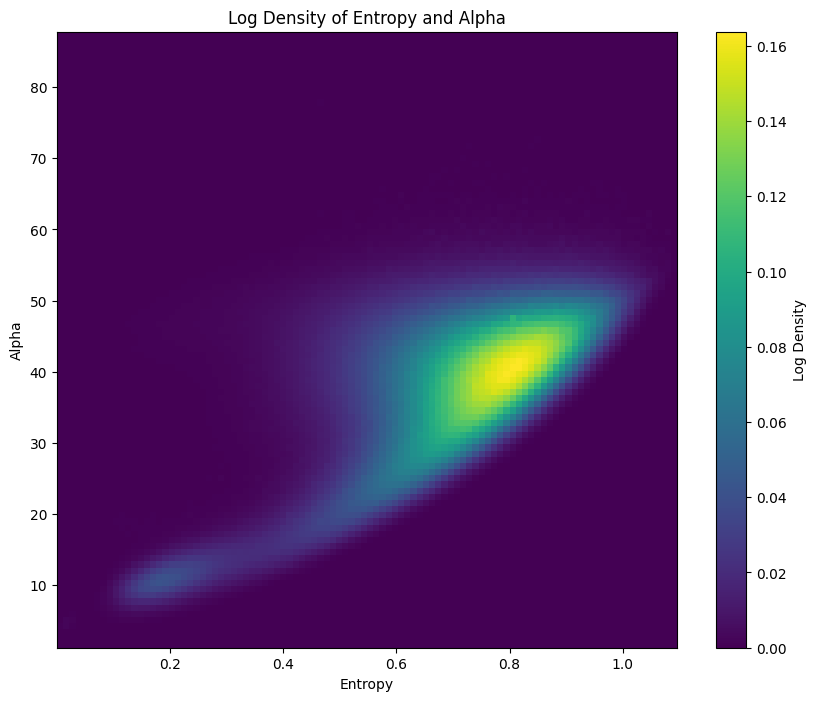

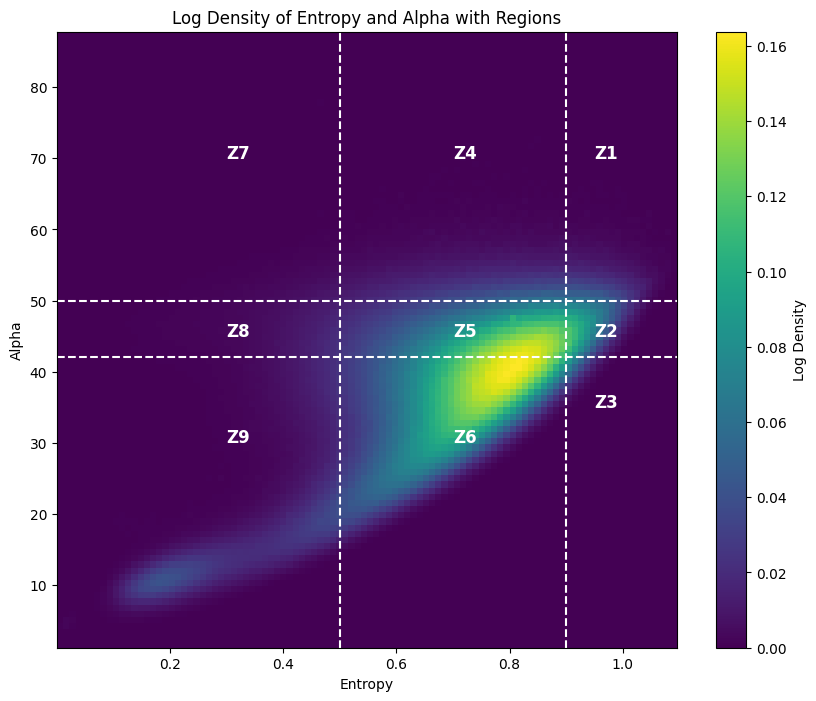

SystemExit: 

/usr/local/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [44]:
pauli_vector = compute_pauli_vector(hh_data, hv_data, vh_data, vv_data)
reference_vector = np.array([1, 0, 0], dtype=np.complex64)
entropy, alpha, Z = cloude_pottier_decomposition(pauli_vector, reference_vector,  window_size=5, block_size=256)

output_dir = "/workspaces/Polarimetric_landcover/data/SatSao_MonteMaiz_cordoba/output"

with open(os.path.join(output_dir, "entropy.npy"), 'wb') as f:
    np.save(f, entropy)

with open(os.path.join(output_dir, "alpha.npy"), 'wb') as f:
    np.save(f, alpha)

with open(os.path.join(output_dir, "Z.npy"), 'wb') as f:
    np.save(f, Z)

plot_entropy_alpha_density(alpha, entropy)
plot_entropy_alpha_density_with_regions(alpha, entropy)

sys.exit()

# labels = {
#           0: "NaN",
#           1: "Forest and canopy structures", 
#           2: "Cloud", 
#           3: "Not possible region",
#           4: "Forestry or double bounce",
#           5: "Vegetation",
#           6: "Random surface propagation",
#           7: "Dihedral scatterer",
#           8: "Dipole",
#           9: "X-Bragg surface"
#           }

# colors = {
#     0: "black",
#     1: "darkgreen",
#     2: "royalblue",
#     3: "crimson",
#     4: "darkorange",
#     5: "gold",
#     6: "teal",
#     7: "indigo",
#     8: "deeppink",
#     9: "saddlebrown"
# }

# plot_land_classification(Z, labels, colors)

Associate these output with geographic coordinates
+ 4 corners (longitude and latitude) are given in the product .xemt file corresponding to a titled rectangle
+ Classify corners into down_left, up_left, down_right, and up_right 
+ Create geographic 2D meshgrids
+ Create xarray for one original data (HH) and the land classification 
+ Plot the latitude and longitude mesh grid and the original data


In [8]:

def classify_corners(corners):
    """
    Classify corners into down_left, up_left, down_right, and up_right.

    Parameters:
        corners (list of lists or tuples): List of four corner points, 
                                           each as [latitude, longitude].

    Returns:
        dict: A dictionary with classified corners.
    """
    # Sort points by latitude
    corners = sorted(corners, key=lambda p: p[0])  # Sort by latitude (north-south)
    
    # Split into lower and upper halves
    lower_half = sorted(corners[:2], key=lambda p: p[1])  # Sort by longitude (east-west)
    upper_half = sorted(corners[2:], key=lambda p: p[1])  # Sort by longitude (east-west)
    
    return {
        "down_left": lower_half[0],
        "down_right": lower_half[1],
        "up_left": upper_half[0],
        "up_right": upper_half[1],
    }

def create_geographic_meshgrid(grid_size, corners):
    """
    Create a 2D meshgrid of longitude and latitude based on tilted corner points.

    Parameters:
        grid_size (tuple): Number of rows and columns in the grid (rows, cols).
        corners (dict): Dictionary containing the corner points with keys:
                        'down_left', 'up_left', 'up_right', 'down_right'.
                        Each value is a tuple or list [lat, lon].

    Returns:
        tuple: 2D meshgrid arrays of latitudes and longitudes.
    """
    rows, cols = grid_size

    # Extract the corner points
    down_left = np.array(corners['down_left'])
    up_left = np.array(corners['up_left'])
    up_right = np.array(corners['up_right'])
    down_right = np.array(corners['down_right'])

    # Interpolate latitude and longitude along the edges
    left_edge = np.linspace(down_left, up_left, rows)  # Vertical interpolation on left
    right_edge = np.linspace(down_right, up_right, rows)  # Vertical interpolation on right

    # Interpolate across each row
    lat_mesh = np.zeros((rows, cols))
    lon_mesh = np.zeros((rows, cols))
    for i in range(rows):
        # Horizontal interpolation for each row
        row_points = np.linspace(left_edge[i], right_edge[i], cols)
        lat_mesh[i, :] = row_points[:, 0]
        lon_mesh[i, :] = row_points[:, 1]

    return lat_mesh, lon_mesh

def create_xarray_from_grid(data_array, lat_mesh, lon_mesh):
    """
    Create an xarray.Dataset from a 2D numpy array and grid coordinates.

    Parameters:
        data_array (np.ndarray): 2D numpy array of data values.
        lat_mesh (np.ndarray): 2D numpy array of latitude values.
        lon_mesh (np.ndarray): 2D numpy array of longitude values.

    Returns:
        xarray.Dataset: Dataset containing the data and coordinates.
    """
    # Check dimensions
    assert data_array.shape == lat_mesh.shape == lon_mesh.shape, "Array shapes must match!"

    # Define the dataset
    ds = xr.Dataset(
        {
            "data": (["y", "x"], data_array)
        },
        coords={
            "latitude": (["y", "x"], lat_mesh),
            "longitude": (["y", "x"], lon_mesh)
        }
    )

    return ds



{'down_left': [-33.6022342842935, -62.6629033914949], 'down_right': [-33.5319201504333, -62.3371495659001], 'up_left': [-33.0067016645971, -62.8387399200105], 'up_right': [-32.936870128906, -62.5155618487516]}


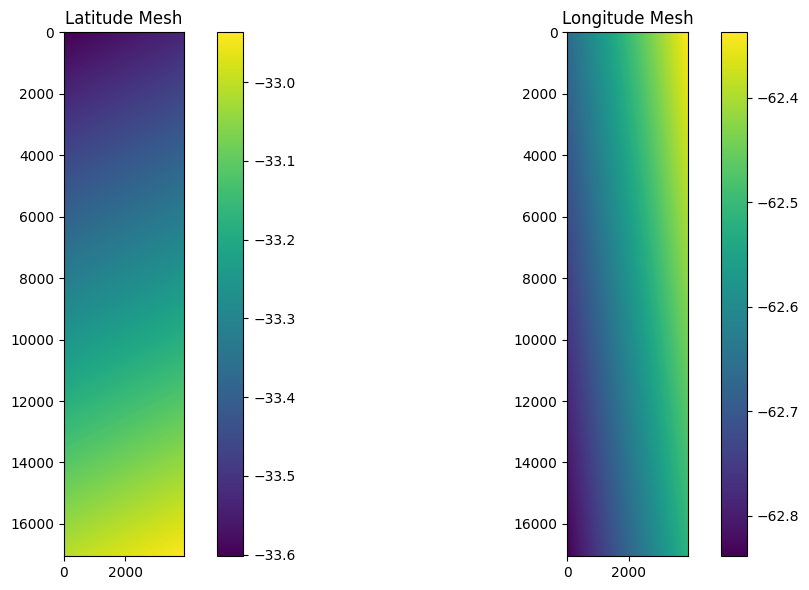

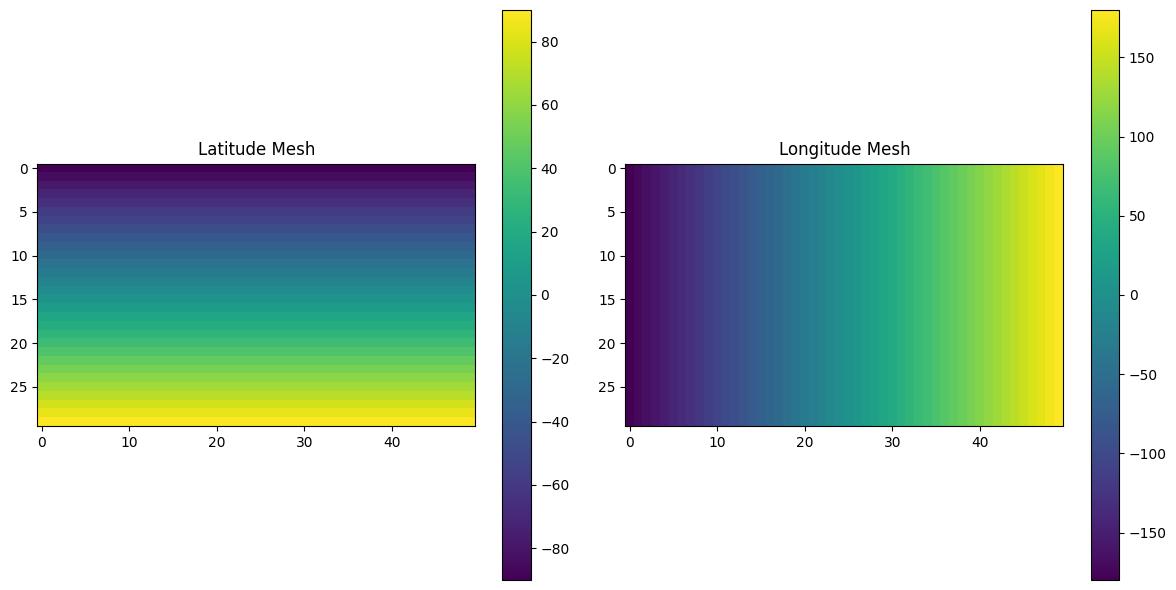

<xarray.Dataset> Size: 1GB
Dimensions:    (y: 17053, x: 3929)
Coordinates:
    latitude   (y, x) float64 536MB -33.6 -33.6 -33.6 ... -32.94 -32.94 -32.94
    longitude  (y, x) float64 536MB -62.66 -62.66 -62.66 ... -62.52 -62.52
Dimensions without coordinates: y, x
Data variables:
    data       (y, x) float32 268MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0


NameError: name 'hh_xarray_reversed' is not defined

In [10]:
hh_magn_array = abs(hh_data)  # Take the magnitude

# Define the corners
corner_points_raw = [[-33.6022342842935, -62.6629033914949], [-33.0067016645971, -62.8387399200105],
                      [-32.936870128906, -62.5155618487516], [-33.5319201504333, -62.3371495659001]]

corner_points = classify_corners(corner_points_raw)
print(corner_points)

# Define grid size
grid_size = hh_magn_array.shape

# Create the meshgrid
latitude_mesh, longitude_mesh = create_geographic_meshgrid(grid_size, corner_points)

# Plot the latitude and longitude meshes for verification
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(latitude_mesh)
plt.colorbar()
plt.title("Latitude Mesh")


plt.subplot(1, 2, 2)
plt.imshow(longitude_mesh)
plt.colorbar()
plt.title("Longitude Mesh")

plt.tight_layout()
plt.show()

# Grille source (irrégulière) avec latitudes/longitudes 2D
lon_source, lat_source = np.meshgrid(
    np.linspace(-180, 180, 50),  # longitudes irrégulières
    np.linspace(-90, 90, 30)    # latitudes irrégulières
)
# Plot the latitude and longitude meshes for verification
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(lat_source)
plt.colorbar()
plt.title("Latitude Mesh")


plt.subplot(1, 2, 2)
plt.imshow(lon_source)
plt.colorbar()
plt.title("Longitude Mesh")

plt.tight_layout()
plt.show()

# Create the xarray.Dataset
hh_xarray = create_xarray_from_grid(hh_magn_array, latitude_mesh, longitude_mesh)
print(hh_xarray)

flipped = {''}

# Save xarray.DataArray or xarray.Dataset to NetCDF
output_dir = "/workspaces/Polarimetric_landcover/data/SatSao_MonteMaiz_cordoba/output"
if os.path.exists(os.path.join(output_dir, "hh_xarray.nc")):
    os.remove(os.path.join(output_dir, "hh_xarray.nc"))
hh_xarray.to_netcdf(os.path.join(output_dir, "hh_xarray.nc"), mode="w")

output_dir = "/workspaces/Polarimetric_landcover/data/SatSao_MonteMaiz_cordoba/output"
if os.path.exists(os.path.join(output_dir, "hh_xarray_reversed.nc")):
    os.remove(os.path.join(output_dir, "hh_xarray_reversed.nc"))
hh_xarray_reversed .to_netcdf(os.path.join(output_dir, "hh_xarray_reversed .nc"), mode="w")

sys.exit()
print("Horizontal flip")
horizontal_flip = hh_magn_array[::-1, :]
hh_xarray_horizontal_flip = create_xarray_from_grid(horizontal_flip, latitude_mesh, longitude_mesh)
hh_xarray_horizontal_flip.to_netcdf(os.path.join(output_dir, "hh_xarray_horizontal_flip.nc"), mode="w")

print("Vertical flip")
vertical_flip= hh_magn_array[:, ::-1]
hh_xarray_vertical_flip = create_xarray_from_grid(vertical_flip, latitude_mesh, longitude_mesh)
hh_xarray_vertical_flip.to_netcdf(os.path.join(output_dir, "hh_xarray_vertical_flip.nc"), mode="w")

print("Central flip")
central_flip = hh_magn_array[::-1, ::-1]
hh_xarray_central_flip= create_xarray_from_grid(central_flip, latitude_mesh, longitude_mesh)
hh_xarray_central_flip.to_netcdf(os.path.join(output_dir, "hh_xarray_central_flip.nc"), mode="w")

# Select the 'data' variable as an xarray.DataArray
hh_data_array = hh_xarray['data']

# Percentile scaling for visualization
lower = np.percentile(hh_data_array, 2)
upper = np.percentile(hh_data_array, 98)

# Plot the hh DataArray with percentile scaling
plt.imshow(hh_data_array, vmin=lower, vmax=upper)
plt.colorbar(label="Value")
plt.title("Data Visualization with Percentile Scaling")
plt.show()

# Plot the hh data on a regular geometric grid (latitude / longitude)
plt.figure()
plt.pcolormesh(hh_data_array['longitude'], hh_data_array['latitude'], hh_data_array.data, vmin=lower, vmax=upper)

# Ensure equal scaling for both axes
plt.gca().set_aspect('equal', adjustable='box')

# Optionally, add labels and a colorbar for better readability
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.title("Original hh plot on regular geometric grid")
plt.colorbar(label="Value")

Download ESA data with land classification for verification
+ Create xarray from these data
+ Plot the land classification with corresponding labels

In [ ]:
# Install required packages
!pip install -q earthengine-api geemap
# Change this to your EE Project (find your project name at https://code.earthengine.google.com/)
EE_PROJECT='ee-renaudhedouin'
# Import required libraries
import time
import pprint
import ee
import geemap
from datetime import datetime

# Authenticate and initialize the Earth Engine API
try:
    ee.Initialize(project=EE_PROJECT)
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project=EE_PROJECT)

# Define the bounding box coordinates, the smallest square box containting the tilted box
bounding_box = ee.Geometry.Rectangle([
    -62.8387399200105, -33.6022342842935 ,  # Lower Left (longitude, latitude)
    -62.3371495659001, -32.936870128906    # Upper Right (longitude, latitude)
])

# Load Google Earth Engine datasets
# Dynamic World dataset (Sentinel-2 derived)
dynamic_world = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')

# ESA WorldCover dataset (Land Cover)
esa_worldcover = ee.ImageCollection("ESA/WorldCover/v200")

# Define a date range for filtering the Dynamic World dataset
start_date = '2019-01-01'
end_date = '2019-06-01'

# Get the latest ESA Land Cover image
esa_image = esa_worldcover.filterBounds(bounding_box).first().clip(bounding_box)

# Export ESA Land Cover image to Google Drive as a COG
esa_task = ee.batch.Export.image.toDrive(
    image = esa_image.toFloat(),
    description='ESA_LandCover_COG',
    folder='EarthEngineExports',
    fileNamePrefix='ESA_LandCover',
    region=bounding_box.getInfo()['coordinates'],
    scale=5,  # Adjust scale (spatial resolution) as required
    crs='EPSG:4326',
    fileFormat='GeoTIFF',
    formatOptions={
        'cloudOptimized': True
    },
    maxPixels=1e13  # Set the maximum number of pixels
)
esa_task.start()

# Suivi de la tâche
while esa_task.active():
    print('Tâche en cours...')
    time.sleep(10)

print('État final de la tâche :')
pprint.pprint(esa_task.status())

# Check the task status
# print('Dynamic World export task:', dw_task.status())
print('ESA Land Cover export task:', esa_task.status())

# Could add automatic data organization

In [13]:
base_dir = "/home/renaud/Polarimetric_landcover/data/SatSao_MonteMaiz_cordoba"
os.chdir(base_dir)

esa_path = os.path.join(base_dir, "ESA_LandCover.tif")

# Open the file using rasterio
with rasterio.open(esa_path) as src:
    esa_img = src.read(1)  # Read the first band (adjust if needed)
    esa_meta = src.meta  # Metadata of the TIFF file

# Set NaN to 0
esa_img_no_nan = np.nan_to_num(esa_img, nan=0)
print(f"esa_img shape: {esa_img_no_nan.shape}")

# Define the corners
rectangle_box_points = {
    "down_left": [-62.8387399200105, -33.6022342842935],
    "up_left": [-62.3371495659001, -33.6022342842935],
    "up_right": [-62.3371495659001, -32.936870128906],
    "down_right": [-62.8387399200105, -32.936870128906]
}

# Define grid size
grid_size = esa_img_no_nan.shape
print(grid_size)

# Create the meshgrid
latitude_mesh, longitude_mesh = create_geographic_meshgrid(grid_size, rectangle_box_points)

# Create the xarray.Dataset
esa_xarray = create_xarray_from_grid(esa_img_no_nan, latitude_mesh, longitude_mesh)
lon_target = np.linspace(-62.8387399200105, -62.3371495659001, grid_size[1])
lat_target = np.linspace(-33.6022342842935, -32.936870128906, grid_size[0])

target_xarray = xr.DataArray(esa_img_no_nan,
        coords={"latitude_line": lat_target, "longitude_line": lon_target}, 
        name='data'
    )

# Save xarray.DataArray or xarray.Dataset to NetCDF
target_xarray.to_netcdf("/home/renaud/Polarimetric_landcover/data/SatSao_MonteMaiz_cordoba/output/target_xarray.nc")
sys.exit()

# Define land cover classes and their colors
land_cover_classes = {
    0: "NaN",
    10: "Trees",
    20: "Shrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Built-up",
    60: "Bare / Sparse Vegetation",
    70: "Snow and Ice",
    80: "Permanent Water Bodies",
    90: "Herbaceous Wetland",
    95: "Mangroves",
    100: "Moss and Lichen"
}

colors = {
    0: "#000000",  #"Nan"
    10: "#006400",  # Trees
    20: "#ffbb22",  # Shrubland
    30: "#ffff4c",  # Grassland
    40: "#f096ff",  # Cropland
    50: "#fa0000",  # Built-up
    60: "#b4b4b4",  # Bare/Sparse
    70: "#f0f0f0",  # Snow/Ice
    80: "#0064c8",  # Water
    90: "#0096a0",  # Wetland
    95: "#00cf75",  # Mangroves
    100: "#f9f9a0",  # Moss/Lichen
}

# Plot the land cover image
plot_land_classification(esa_img_no_nan, land_cover_classes, colors)

esa_img shape: (1236, 932)
(1236, 932)


SystemExit: 

/usr/local/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Interpolate the xarray_1 (original hh) onto xarray_2's grid (esa image) (currently doesn´t look good, geographic problem?)

In [14]:

def interpolate_xarray_2(source_xr, target_xr, variable_name):
    """
    Interpole un xarray source (avec grilles irrégulières) sur un xarray cible.

    Arguments :
        - source_xr : xarray.DataArray
            Le xarray source avec des coordonnées irrégulières (lon et lat en 2D).
        - target_xr : xarray.DataArray
            Le xarray cible avec une grille régulière (ou autre).
        - variable_name : str
            Nom de la variable à interpoler dans le xarray source.

    Retourne :
        - result_xr : xarray.DataArray
            Le xarray interpolé sur la grille cible.
    """
    # Extraire les coordonnées et les valeurs de la source
    lon_source = source_xr["longitude"].values
    lat_source = source_xr["latitude"].values
    data_source = source_xr[variable_name].values

    # Aplatir les coordonnées irrégulières pour l'interpolation
    points_source = np.column_stack((lon_source.ravel(), lat_source.ravel()))
    values_source = data_source.ravel()

    # Extraire les coordonnées cibles
    lon_target = target_xr["longitude_line"].values
    lat_target = target_xr["latitude_line"].values
    lon_grid, lat_grid = np.meshgrid(lon_target, lat_target)
    points_target = np.column_stack((lon_grid.ravel(), lat_grid.ravel()))

    # Effectuer l'interpolation linéaire
    interpolated_data = griddata(
        points_source,    # Points irréguliers source
        values_source,    # Valeurs à interpoler
        points_target,    # Points de la grille cible
        method="nearest"  # Interpolation linéaire
    )

    # Reshape pour correspondre à la grille cible
    interpolated_data = interpolated_data.reshape(lon_grid.shape)

    # Créer un nouveau xarray avec les données interpolées
    result_xr = xr.DataArray(
        interpolated_data,
        dims=("lat", "lon"),
        coords={"lon": lon_target, "lat": lat_target},
        name=variable_name
    )

    return result_xr

(932,)
(1236,)
(1236, 932)


SystemExit: 

/usr/local/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


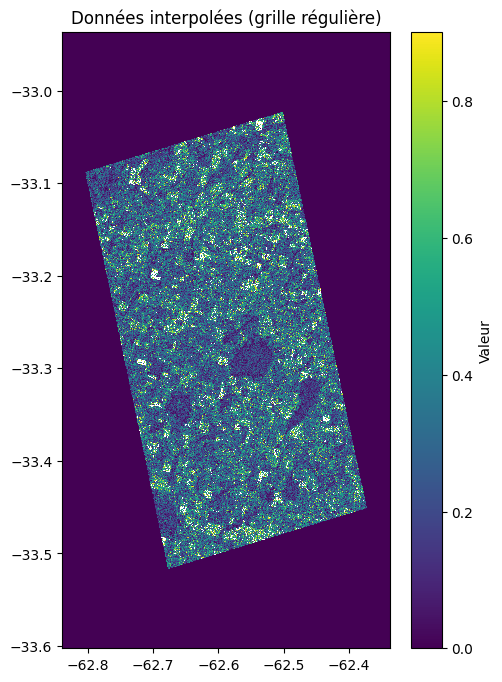

In [15]:

# Load the xarrays from the specified paths
base_dir = "/home/renaud/Polarimetric_landcover/data/SatSao_MonteMaiz_cordoba/output"
xarray_1 = xr.open_dataset(os.path.join(base_dir, "hh_xarray.nc"))
target_xarray = xr.open_dataset(os.path.join(base_dir, "target_xarray.nc"))

xslice = slice(None)  
yslice = slice(None)

# Percentile scaling for visualization
lower = np.percentile(xarray_1['data'], 2)
upper = np.percentile(xarray_1['data'], 98)

xarray_1_subset = xarray_1.isel(y=yslice, x=xslice)
xarray_1_clipped = xarray_1.where((xarray_1.data >= lower) & (xarray_1.data <= upper), drop=True)
# xarray_1_clipped = xarray_1

# Interpolate xarray_1 onto xarray_2's grid
interpolated_xarray_1 = interpolate_xarray_2(xarray_1_clipped, target_xarray, 'data')

# Plot the original data
plt.figure(figsize=(18, 8))

# plt.subplot(2, 2, 1)
    # Données originales
print(interpolated_xarray_1["lon"].shape)
print(interpolated_xarray_1["lat"].shape)
print(interpolated_xarray_1.data.shape)
# print(interpolated_xarray_1['data'])

# plt.subplot(1, 3, 1)
# plt.scatter(interpolated_xarray_1["lon"], interpolated_xarray_1["lat"], c=interpolated_xarray_1.data, cmap="viridis")
# plt.colorbar(label="Valeur")

# Données interpolées
plt.subplot(1, 3, 2)
plt.pcolormesh(interpolated_xarray_1["lon"], interpolated_xarray_1["lat"], interpolated_xarray_1, shading="auto", cmap="viridis")
plt.colorbar(label="Valeur")
plt.title("Données interpolées (grille régulière)")
sys.exit()

# plt.subplot(2, 2, 2)
# plt.pcolormesh(interpolated_xarray_2['longitude'], interpolated_xarray_2['latitude'], interpolated_xarray_2.data, shading="auto")
# plt.title("Original Data (Normalized)")
# plt.colorbar(label="Normalized Value")


# # Save the result to a NetCDF file
# interpolated_xarray.to_netcdf(os.path.join(base_dir, "interpolated_result.nc"))

# Plot the original, target, interpolated, and normalized overlay
plt.figure(figsize=(18, 8))

# Normalize data for consistent comparison
xarray_1_min, xarray_1_max = np.nanmin(xarray_1_clipped.data), np.nanmax(xarray_1_clipped.data)
xarray_2_min, xarray_2_max = np.nanmin(xarray_2.data), np.nanmax(xarray_2.data)
xarray_1_normalized = (xarray_1_clipped.data - xarray_1_min) / (xarray_1_max - xarray_1_min)
xarray_2_normalized = (xarray_2.data - xarray_2_min) / (xarray_2_max - xarray_2_min)

# Plot the original data
plt.subplot(2, 2, 1)
plt.pcolormesh(xarray_1_clipped['longitude'], xarray_1_clipped['latitude'], xarray_1_clipped.data, shading="auto")
plt.title("Original Data (Normalized)")
plt.colorbar(label="Normalized Value")

# Plot the target grid
plt.subplot(2, 2, 2)
plt.pcolormesh(xarray_2['longitude'], xarray_2['latitude'], xarray_2.data, shading="auto")
plt.title("Target Grid (Normalized)")
plt.colorbar(label="Normalized Value")

# Plot the interpolated data
plt.subplot(2, 2, 3)
plt.pcolormesh(interpolated_xarray['longitude'], interpolated_xarray['latitude'], interpolated_xarray.data, shading="auto")
plt.title("Interpolated Data")
plt.colorbar(label="Value")

# Overlay normalized original and target data
plt.subplot(2, 2, 4)
plt.pcolormesh(xarray_1_normalized['longitude'], xarray_1_normalized['latitude'], xarray_1_normalized, shading="auto", alpha=0.75, cmap="Blues")
plt.pcolormesh(xarray_2_normalized['longitude'], xarray_2_normalized['latitude'], xarray_2_normalized, shading="auto", alpha=0.25, cmap="Reds")
plt.title("Overlay: Original (Blue) & Target (Red)")
plt.colorbar(label="Normalized Value")

# plt.title(name)

plt.tight_layout()
plt.show()

print("Interpolation completed and saved to interpolated_result.nc")

In [53]:

# Load the xarrays from the specified paths
base_dir = "/home/renaud/Polarimetric_landcover/data/SatSao_MonteMaiz_cordoba/output"
xarray_1 = xr.open_dataset(os.path.join(base_dir, "hh_xarray.nc"))
xarray_2 = xr.open_dataset(os.path.join(base_dir, "esa_xarray.nc"))

xslice = slice(None)  
yslice = slice(None)

# Percentile scaling for visualization
lower = np.percentile(xarray_1['data'], 2)
upper = np.percentile(xarray_1['data'], 98)

print(xarray_1)
xarray_1_subset = xarray_1.isel(y=yslice, x=xslice)
xarray_1_clipped = xarray_1.where((xarray_1.data >= lower) & (xarray_1.data <= upper), drop=True)
# xarray_1_clipped = xarray_1

# Interpolate xarray_1 onto xarray_2's grid
interpolated_xarray_1, interpolated_xarray_2 = interpolate_xarray_new(xarray_1_clipped, xarray_2, 'data')

# Plot the original data
plt.figure(figsize=(18, 8))

plt.subplot(2, 2, 1)
plt.pcolormesh(interpolated_xarray_1['longitude'], interpolated_xarray_1['latitude'], interpolated_xarray_1.data, shading="auto")
plt.title("Original Data (Normalized)")
plt.colorbar(label="Normalized Value")

plt.subplot(2, 2, 2)
plt.pcolormesh(interpolated_xarray_2['longitude'], interpolated_xarray_2['latitude'], interpolated_xarray_2.data, shading="auto")
plt.title("Original Data (Normalized)")
plt.colorbar(label="Normalized Value")

plt.subplot(2, 2, 3)
plt.pcolormesh(interpolated_xarray_3['longitude'], interpolated_xarray_3['latitude'], interpolated_xarray_3.data, shading="auto")
plt.title("Original Data (Normalized)")
plt.colorbar(label="Normalized Value")

plt.subplot(2, 2, 4)
plt.pcolormesh(interpolated_xarray_4['longitude'], interpolated_xarray_4['latitude'], interpolated_xarray_4.data, shading="auto")
plt.title("Original Data (Normalized)")
plt.colorbar(label="Normalized Value")
sys.exit()
# # Save the result to a NetCDF file
# interpolated_xarray.to_netcdf(os.path.join(base_dir, "interpolated_result.nc"))

# Plot the original, target, interpolated, and normalized overlay
plt.figure(figsize=(18, 8))

# Normalize data for consistent comparison
xarray_1_min, xarray_1_max = np.nanmin(xarray_1_clipped.data), np.nanmax(xarray_1_clipped.data)
xarray_2_min, xarray_2_max = np.nanmin(xarray_2.data), np.nanmax(xarray_2.data)
xarray_1_normalized = (xarray_1_clipped.data - xarray_1_min) / (xarray_1_max - xarray_1_min)
xarray_2_normalized = (xarray_2.data - xarray_2_min) / (xarray_2_max - xarray_2_min)

# Plot the original data
plt.subplot(2, 2, 1)
plt.pcolormesh(xarray_1_clipped['longitude'], xarray_1_clipped['latitude'], xarray_1_clipped.data, shading="auto")
plt.title("Original Data (Normalized)")
plt.colorbar(label="Normalized Value")

# Plot the target grid
plt.subplot(2, 2, 2)
plt.pcolormesh(xarray_2['longitude'], xarray_2['latitude'], xarray_2.data, shading="auto")
plt.title("Target Grid (Normalized)")
plt.colorbar(label="Normalized Value")

# Plot the interpolated data
plt.subplot(2, 2, 3)
plt.pcolormesh(interpolated_xarray['longitude'], interpolated_xarray['latitude'], interpolated_xarray.data, shading="auto")
plt.title("Interpolated Data")
plt.colorbar(label="Value")

# Overlay normalized original and target data
plt.subplot(2, 2, 4)
plt.pcolormesh(xarray_1_normalized['longitude'], xarray_1_normalized['latitude'], xarray_1_normalized, shading="auto", alpha=0.75, cmap="Blues")
plt.pcolormesh(xarray_2_normalized['longitude'], xarray_2_normalized['latitude'], xarray_2_normalized, shading="auto", alpha=0.25, cmap="Reds")
plt.title("Overlay: Original (Blue) & Target (Red)")
plt.colorbar(label="Normalized Value")

# plt.title(name)

plt.tight_layout()
plt.show()

print("Interpolation completed and saved to interpolated_result.nc")

<xarray.Dataset> Size: 1GB
Dimensions:    (y: 17053, x: 3929)
Coordinates:
    latitude   (y, x) float64 536MB ...
    longitude  (y, x) float64 536MB ...
Dimensions without coordinates: y, x
Data variables:
    data       (y, x) float32 268MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Interpolation completed in 42.47 seconds.


ValueError: coordinate latitude has dimensions ('y', 'x'), but these are not a subset of the DataArray dimensions ()

In [ ]:

# Exemple d'utilisation
if __name__ == "__main__":
    # Exemple de xarray source (irrégulier)
    lon_source = np.random.uniform(0, 10, (20, 20))
    lat_source = np.random.uniform(0, 10, (20, 20))
    data_source = np.sin(lon_source / 2) + np.cos(lat_source / 2)

    source_xr = xr.Dataset(
        {
            "data": (("x", "y"), data_source)
        },
        coords={
            "latitude": (("x", "y"), lat_source),
            "longitude": (("x", "y"), lon_source)
        }
    )

    # Exemple de xarray cible (régulier)
    lon_target = np.linspace(0, 10, 50)
    lat_target = np.linspace(0, 10, 50)
    lon_mesh, lat_mesh = np.meshgrid(lon_target, lat_target)
    target_xr = xr.Dataset(
                coords={
            "latitude": (("x", "y"), lat_mesh),
            "longitude": (("x", "y"), lon_mesh)
        }
    )

    

    # Interpolation vers la grille cible
    interpolated_xr = interpolate_xarray_new(source_xr, target_xr, "variable")

    # Interpolation inverse vers la grille source
    # reinterpolated_xr = interpolate_xarray(interpolated_xr, source_xr, "variable")

    # Tracé des résultats
    plt.figure(figsize=(15, 5))

    # Données originales
    plt.subplot(1, 3, 1)
    plt.scatter(source_xr["longitude"], source_xr["latitude"], c=source_xr["variable"], cmap="viridis")
    plt.colorbar(label="Valeur")
    plt.title("Données originales (grille irrégulière)")

    # Données interpolées
    plt.subplot(1, 3, 2)
    plt.pcolormesh(interpolated_xr["longitude"], interpolated_xr["latitude"], interpolated_xr["variable"], shading="auto", cmap="viridis")
    plt.colorbar(label="Valeur")
    plt.title("Données interpolées (grille régulière)")

    # # Données réinterpolées
    # plt.subplot(1, 3, 3)
    # plt.scatter(source_xr["lon"], source_xr["lat"], c=reinterpolated_xr, cmap="viridis")
    # plt.colorbar(label="Valeur")
    # plt.title("Données réinterpolées sur grille irrégulière")

    plt.tight_layout()
    plt.show()

KeyError: "No variable named 'variable'. Variables on the dataset include ['data', 'longitude', 'latitude']"